

# STEP 1 — PROJECT BOOTSTRAP + DATA LOAD & SANITY CHECKS



In [1]:





import os
import sys
import random
import warnings
from datetime import datetime, timezone

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

VERSIONS = {
    "python": sys.version.split(" ")[0],
    "numpy": np.__version__,
    "pandas": pd.__version__,
}


def first_existing_path(candidates):
    """Return the first path that exists from a list of candidates, else raise with a clear, username-agnostic message."""
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(
        "Reviews.csv not found. Set RAW_DATA_PATH to the correct location, e.g., 'Sachin_NLP\\Dataset\\Reviews.csv'."
    )


def mask_path(path_str: str) -> str:
    """Replace the user home directory portion with <HOME> so usernames are never printed."""
    home = os.path.expanduser("~")

    norm_path = os.path.normpath(path_str)
    norm_home = os.path.normpath(home)
    if norm_path.lower().startswith(norm_home.lower()):
        masked = norm_path.replace(home, "<HOME>")
    else:
        masked = norm_path
    return masked


RAW_DATA_PATH = first_existing_path([
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin_NLP", "Dataset", "Reviews.csv"),
    os.path.join("Dataset", "Reviews.csv"),
    "Reviews.csv",
])

project_root = os.path.abspath(os.path.join(os.path.dirname(RAW_DATA_PATH), os.pardir))
processed_dir = os.path.join(project_root, "processed")
os.makedirs(processed_dir, exist_ok=True)
PROCESSED_CSV_PATH = os.path.join(processed_dir, "amazon_reviews_clean.csv")

dtype_map = {
    "Id": "int64",
    "ProductId": "string",
    "UserId": "string",
    "ProfileName": "string",
    "HelpfulnessNumerator": "int64",
    "HelpfulnessDenominator": "int64",
    "Score": "int64",
    "Time": "int64",
    "Summary": "string",
    "Text": "string",
}

df = pd.read_csv(RAW_DATA_PATH, dtype=dtype_map, low_memory=False)

required_cols = list(dtype_map.keys())
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

n_rows_raw, n_cols_raw = df.shape
duplicate_id_count = int(df.duplicated(subset=["Id"]).sum())

null_counts = df[["Summary", "Text", "ProfileName"]].isna().sum().to_dict()
invalid_score_rows = int((~df["Score"].between(1, 5)).sum())

invalid_helpfulness_rows_prefix = int((
    (df["HelpfulnessDenominator"] < 0)
    | (df["HelpfulnessNumerator"] < 0)
    | (df["HelpfulnessNumerator"] > df["HelpfulnessDenominator"])
).sum())

df["ReviewTimeUTC"] = pd.to_datetime(df["Time"], unit="s", utc=True)
df["Summary"] = df["Summary"].fillna("").str.strip()
df["Text"] = df["Text"].fillna("").str.strip()

before = df.shape[0]
df = df[df["Text"].str.len() > 0].copy()
dropped_empty_text = int(before - df.shape[0])

over_mask = df["HelpfulnessNumerator"] > df["HelpfulnessDenominator"]
if over_mask.any():
    df.loc[over_mask, "HelpfulnessNumerator"] = df.loc[over_mask, "HelpfulnessDenominator"].astype("int64")

df = df[df["Score"].between(1, 5)].copy()

df["summary_len"] = df["Summary"].str.len()
df["text_len"] = df["Text"].str.len()

df.to_csv(PROCESSED_CSV_PATH, index=False)

print("=== STEP 1: BOOTSTRAP & DATA CHECKS — SUMMARY ===")
print(f"Python: {VERSIONS['python']}, NumPy: {VERSIONS['numpy']}, Pandas: {VERSIONS['pandas']}")
print(f"Raw shape: {n_rows_raw} rows x {n_cols_raw} cols")
print(f"Missing required columns: {'None' if not missing_cols else ', '.join(missing_cols)}")
print(f"Duplicate Id count: {duplicate_id_count}")
print(f"Null (Summary/Text/ProfileName): {null_counts['Summary']}/{null_counts['Text']}/{null_counts['ProfileName']}")
print(f"Invalid helpfulness rows (pre-fix): {invalid_helpfulness_rows_prefix}")
print(f"Invalid score rows (pre-filter): {invalid_score_rows}")
print(f"Dropped empty-text rows: {dropped_empty_text}")
print(f"Processed CSV saved to: {mask_path(PROCESSED_CSV_PATH)}") 
print("===============================================")




=== STEP 1: BOOTSTRAP & DATA CHECKS — SUMMARY ===
Python: 3.12.8, NumPy: 1.26.4, Pandas: 2.3.1
Raw shape: 568454 rows x 10 cols
Missing required columns: None
Duplicate Id count: 0
Null (Summary/Text/ProfileName): 27/0/26
Invalid helpfulness rows (pre-fix): 2
Invalid score rows (pre-filter): 0
Dropped empty-text rows: 0
Processed CSV saved to: <HOME>\Downloads\Sachin  NLP\processed\amazon_reviews_clean.csv




# STEP 2 — EDA + DATASET SPLITTING



=== EDA: Basic Info ===
Rows: 568,454
Score distribution (counts):
Score
1     52268
2     29769
3     42640
4     80655
5    363122

Score distribution (proportions):
Score
1    0.0919
2    0.0524
3    0.0750
4    0.1419
5    0.6388

Text length (chars) — summary:
count    568454.00
mean        436.22
std         445.34
min          12.00
50%         302.00
75%         527.00
90%         877.00
95%        1202.00
99%        2166.00
max       21409.00


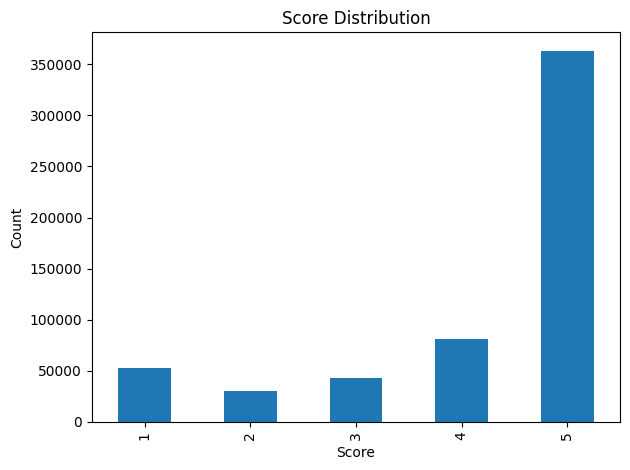

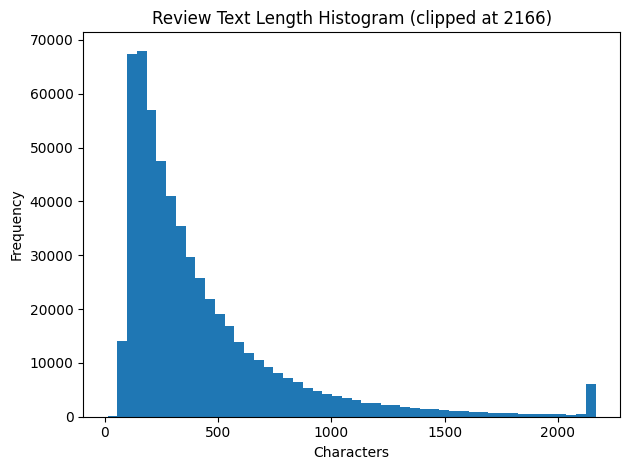


=== Label sanity ===
3-class label counts: Counter({1: 443777, -1: 82037, 0: 42640})
2-class label counts (3-star removed): Counter({1: 443777, 0: 82037})

3-class — split label balance
  Train: {-1: 65630, 0: 34112, 1: 355021} {-1: 0.1443, 0: 0.075, 1: 0.7807}
  Val  : {-1: 2051, 0: 1066, 1: 11094} {-1: 0.1443, 0: 0.075, 1: 0.7807}
  Test : {-1: 14356, 0: 7462, 1: 77662} {-1: 0.1443, 0: 0.075, 1: 0.7807}

2-class — split label balance
  Train: {0: 65630, 1: 355021} {0: 0.156, 1: 0.844}
  Val  : {0: 2051, 1: 11094} {0: 0.156, 1: 0.844}
  Test : {0: 14356, 1: 77662} {0: 0.156, 1: 0.844}

=== Saved split files ===
train_3: <HOME>\Downloads\Sachin  NLP\processed\reviews_train_3cls.csv
val_3: <HOME>\Downloads\Sachin  NLP\processed\reviews_val_3cls.csv
test_3: <HOME>\Downloads\Sachin  NLP\processed\reviews_test_3cls.csv
train_2: <HOME>\Downloads\Sachin  NLP\processed\reviews_train_2cls.csv
val_2: <HOME>\Downloads\Sachin  NLP\processed\reviews_val_2cls.csv
test_2: <HOME>\Downloads\Sachin  N

In [2]:




import os
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

SEED = 42
rng = np.random.RandomState(SEED)


def first_existing_path(candidates):
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(
        "Cannot find processed CSV. Please set PROCESSED_CSV_PATH to your cleaned file "
        "e.g., 'Sachin_NLP\\processed\\amazon_reviews_clean.csv'."
    )

def mask_path(path_str: str) -> str:
    """Replace the home directory with <HOME> to avoid exposing the OS username in outputs."""
    home = os.path.expanduser("~")
    norm_path = os.path.normpath(path_str)
    norm_home = os.path.normpath(home)
    if norm_path.lower().startswith(norm_home.lower()):
        return norm_path.replace(home, "<HOME>")
    return norm_path


PROCESSED_CSV_PATH = first_existing_path([
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin  NLP", "processed", "amazon_reviews_clean.csv"),
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin_NLP", "processed", "amazon_reviews_clean.csv"),
    os.path.join("processed", "amazon_reviews_clean.csv"),
    "amazon_reviews_clean.csv",
])

project_root = os.path.abspath(os.path.join(os.path.dirname(PROCESSED_CSV_PATH), os.pardir))
processed_dir = os.path.join(project_root, "processed")
os.makedirs(processed_dir, exist_ok=True)


df = pd.read_csv(PROCESSED_CSV_PATH, low_memory=False)


for col in ["Score", "Summary", "Text"]:
    if col not in df.columns:
        raise ValueError(f"Required column missing: {col}")


if "summary_len" not in df.columns:
    df["summary_len"] = df["Summary"].fillna("").astype(str).str.len()
if "text_len" not in df.columns:
    df["text_len"] = df["Text"].fillna("").astype(str).str.len()

# -------- EDA --------
print("=== EDA: Basic Info ===")
print(f"Rows: {len(df):,}")
print("Score distribution (counts):")
score_counts = df["Score"].value_counts().sort_index()
print(score_counts.to_string())

print("\nScore distribution (proportions):")
print((score_counts / len(df)).round(4).to_string())

print("\nText length (chars) — summary:")
print(df["text_len"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]).round(2).to_string())

# 1) Score distribution
plt.figure()
score_counts.plot(kind="bar")
plt.title("Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()

# 2) Text length histogram
plt.figure()
clip_max = int(np.clip(df["text_len"].quantile(0.99), 500, 5000))
df["text_len"].clip(upper=clip_max).plot(kind="hist", bins=50)
plt.title(f"Review Text Length Histogram (clipped at {clip_max})")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.close()


def map_to_3cls(score: int) -> int:
    if score <= 2:
        return -1
    if score == 3:
        return 0
    return 1

df_3 = df.copy()
df_3["label_3"] = df_3["Score"].astype(int).apply(map_to_3cls)

df_2 = df[df["Score"] != 3].copy()
df_2["label_2"] = (df_2["Score"] >= 4).astype(int)

print("\n=== Label sanity ===")
print("3-class label counts:", Counter(df_3["label_3"]))
print("2-class label counts (3-star removed):", Counter(df_2["label_2"]))


def stratified_splits(frame: pd.DataFrame, label_col: str, test_size: float = 0.2, val_size: float = 0.1):
    """
    Returns: (train_df, val_df, test_df) stratified by label_col.
    Overall: 80% train, 10% val, 10% test.
    """
    train_df, temp_df = train_test_split(
        frame, test_size=test_size, stratify=frame[label_col], random_state=SEED
    )
    relative_val = val_size / (1.0 - test_size)
    val_df, test_df = train_test_split(
        temp_df, test_size=1.0 - relative_val, stratify=temp_df[label_col], random_state=SEED
    )
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

train_3, val_3, test_3 = stratified_splits(df_3, "label_3")
train_2, val_2, test_2 = stratified_splits(df_2, "label_2")

def show_split_stats(name, tr, va, te, label_col):
    def pct(series):
        c = series.value_counts().sort_index()
        p = (c / len(series)).round(4)
        return c.to_dict(), p.to_dict()
    c_tr, p_tr = pct(tr[label_col])
    c_va, p_va = pct(va[label_col])
    c_te, p_te = pct(te[label_col])
    print(f"\n{name} — split label balance")
    print("  Train:", c_tr, p_tr)
    print("  Val  :", c_va, p_va)
    print("  Test :", c_te, p_te)

show_split_stats("3-class", train_3, val_3, test_3, "label_3")
show_split_stats("2-class", train_2, val_2, test_2, "label_2")


paths = {
    "train_3": os.path.join(processed_dir, "reviews_train_3cls.csv"),
    "val_3": os.path.join(processed_dir, "reviews_val_3cls.csv"),
    "test_3": os.path.join(processed_dir, "reviews_test_3cls.csv"),
    "train_2": os.path.join(processed_dir, "reviews_train_2cls.csv"),
    "val_2": os.path.join(processed_dir, "reviews_val_2cls.csv"),
    "test_2": os.path.join(processed_dir, "reviews_test_2cls.csv"),
}

train_3.to_csv(paths["train_3"], index=False)
val_3.to_csv(paths["val_3"], index=False)
test_3.to_csv(paths["test_3"], index=False)
train_2.to_csv(paths["train_2"], index=False)
val_2.to_csv(paths["val_2"], index=False)
test_2.to_csv(paths["test_2"], index=False)

print("\n=== Saved split files ===")
for k, v in paths.items():
    print(f"{k}: {mask_path(v)}") 

print("\nStep 2 complete — EDA done, labels defined (2-class & 3-class), stratified splits saved.")






# STEP 3 — CLASSICAL NLP PIPELINE (TOKENISATION + STEMMING + POS) & BASELINE MODEL



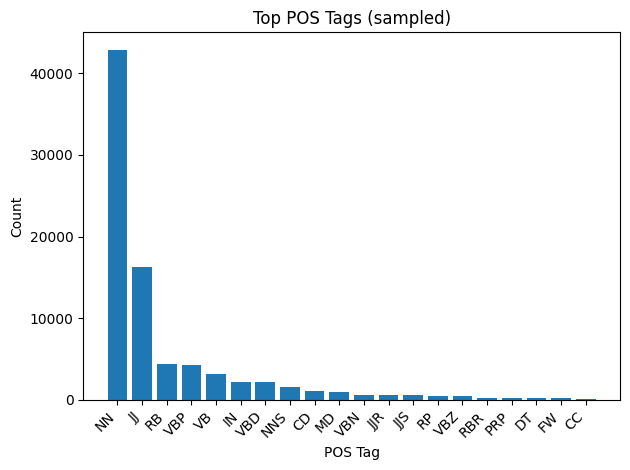


=== TRAIN Metrics ===
Accuracy : 0.9657
F1 (macro/weighted): 0.9392 / 0.9668
Precision: 0.9959 | Recall: 0.9633 | ROC-AUC: 0.9949
Confusion Matrix [rows=true 0..1, cols=pred 0..1]:
[[ 64229   1401]
 [ 13024 341997]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8314    0.9787    0.8990     65630
           1     0.9959    0.9633    0.9793    355021

    accuracy                         0.9657    420651
   macro avg     0.9137    0.9710    0.9392    420651
weighted avg     0.9703    0.9657    0.9668    420651


=== VAL Metrics ===
Accuracy : 0.9518
F1 (macro/weighted): 0.9146 / 0.9534
Precision: 0.9875 | Recall: 0.9550 | ROC-AUC: 0.9860
Confusion Matrix [rows=true 0..1, cols=pred 0..1]:
[[ 1917   134]
 [  499 10595]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7935    0.9347    0.8583      2051
           1     0.9875    0.9550    0.9710     11094

    accuracy                     

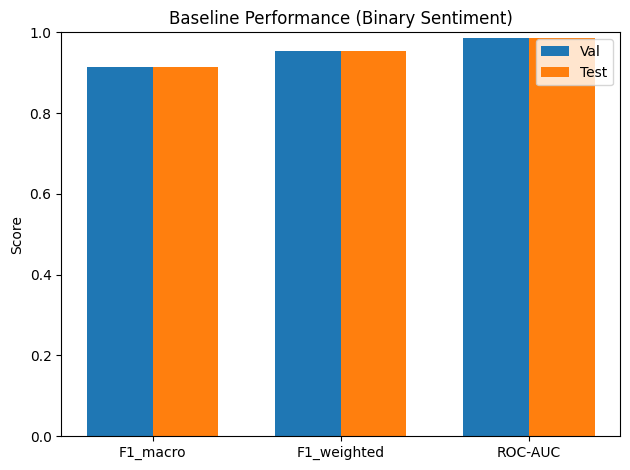


Step 3 complete — Classical NLP pipeline built and evaluated (username-safe).


In [3]:




import os
import re
import warnings
import random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight
import joblib

import nltk
from nltk.stem import PorterStemmer

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


def first_existing_path(candidates):
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(
        "Cannot find processed split CSVs. Set BASE_PROCESSED to your 'processed' folder."
    )

def mask_path(path_str: str) -> str:
    """Replace the home directory with <HOME> so usernames are never printed."""
    home = os.path.expanduser("~")
    norm_path = os.path.normpath(path_str)
    norm_home = os.path.normpath(home)
    if norm_path.lower().startswith(norm_home.lower()):
        return norm_path.replace(home, "<HOME>")
    return norm_path


BASE_PROCESSED = first_existing_path([
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin  NLP", "processed"),
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin_NLP", "processed"),
    "processed"
])

PATHS = {
    "train_2": os.path.join(BASE_PROCESSED, "reviews_train_2cls.csv"),
    "val_2":   os.path.join(BASE_PROCESSED, "reviews_val_2cls.csv"),
    "test_2":  os.path.join(BASE_PROCESSED, "reviews_test_2cls.csv"),
    "train_3": os.path.join(BASE_PROCESSED, "reviews_train_3cls.csv"),
    "val_3":   os.path.join(BASE_PROCESSED, "reviews_val_3cls.csv"),
    "test_3":  os.path.join(BASE_PROCESSED, "reviews_test_3cls.csv"),
    "model_dir": BASE_PROCESSED,
}


train_df = pd.read_csv(PATHS["train_2"])
val_df   = pd.read_csv(PATHS["val_2"])
test_df  = pd.read_csv(PATHS["test_2"])

required = ["Summary", "Text", "label_2"]
for c in required:
    if c not in train_df.columns:
        raise ValueError(f"Column '{c}' missing from train set.")

def combine_text(df: pd.DataFrame) -> pd.Series:
    s = (df["Summary"].fillna("").astype(str).str.strip() + " " +
         df["Text"].fillna("").astype(str).str.strip())
    return s.str.replace(r"\s+", " ", regex=True)

X_train = combine_text(train_df); y_train = train_df["label_2"].astype(int).values
X_val   = combine_text(val_df);   y_val   = val_df["label_2"].astype(int).values
X_test  = combine_text(test_df);  y_test  = test_df["label_2"].astype(int).values


STOPWORDS = {
    "a","an","the","and","or","but","if","while","with","without","for","to","from",
    "of","in","on","at","by","about","as","into","through","over","after","before",
    "between","out","against","during","within","along","across",
    "is","am","are","was","were","be","been","being","do","does","did","doing",
    "have","has","had","having","i","me","my","we","our","you","your","he","him",
    "his","she","her","it","its","they","them","their","this","that","these","those",
    "there","here","not","no","nor","only","own","same","so","than","too","very",
    "can","will","just","don","should","now","because","what","which","who","whom",
    "why","how","when","where","all","any","both","each","few","more","most",
    "other","some","such"
}

ps = PorterStemmer()
TOKEN_RE = re.compile(r"[A-Za-z]{2,}")

def clean_text_basic(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize_stem(text: str):
    text = clean_text_basic(text)
    tokens = TOKEN_RE.findall(text)
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    tokens = [ps.stem(t) for t in tokens]
    return tokens


try:
    nltk.data.find("taggers/averaged_perceptron_tagger_eng")
except LookupError:
    try:
        nltk.download("averaged_perceptron_tagger_eng", quiet=True)
    except Exception:
        nltk.download("averaged_perceptron_tagger", quiet=True)

try:
    from nltk import pos_tag
    pos_tag_available = True
except Exception:
    pos_tag_available = False

def sample_pos_distribution(texts: pd.Series, n=2000):
    if not pos_tag_available:
        return {}
    sample = texts.sample(min(n, len(texts)), random_state=SEED)
    tags = []
    for doc in sample:
        toks = tokenize_stem(doc)[:200]
        if toks:
            tags.extend([t for _, t in pos_tag(toks)])
    return dict(Counter(tags))

pos_counts = sample_pos_distribution(X_train, n=2000)
if pos_counts:
    pos_items = sorted(pos_counts.items(), key=lambda x: x[1], reverse=True)[:20]
    plt.figure()
    plt.bar([k for k,_ in pos_items], [v for _,v in pos_items])
    plt.title("Top POS Tags (sampled)")
    plt.xlabel("POS Tag")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    plt.close()


classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cw_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}

clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer=tokenize_stem,
        preprocessor=None,
        token_pattern=None,
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.9,
        strip_accents="ascii",
        sublinear_tf=True,
        norm="l2"
    )),
    ("logreg", LogisticRegression(
        solver="saga",
        penalty="l2",
        C=1.0,
        max_iter=2000,
        n_jobs=-1,
        class_weight=cw_dict,
        random_state=SEED
    ))
])

clf.fit(X_train, y_train)


def evaluate_binary(model, X, y, split_name):
    y_pred = model.predict(X)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)[:, 1]
        roc = roc_auc_score(y, y_prob)
    elif hasattr(model, "decision_function"):
        y_dec = model.decision_function(X)
        roc = roc_auc_score(y, y_dec)
    else:
        roc = float("nan")

    acc = accuracy_score(y, y_pred)
    f1w = f1_score(y, y_pred, average="weighted")
    f1m = f1_score(y, y_pred, average="macro")
    prec = precision_score(y, y_pred, average="binary", zero_division=0)
    rec  = recall_score(y, y_pred, average="binary", zero_division=0)
    cm = confusion_matrix(y, y_pred, labels=[0, 1])

    print(f"\n=== {split_name} Metrics ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 (macro/weighted): {f1m:.4f} / {f1w:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | ROC-AUC: {roc:.4f}")
    print("Confusion Matrix [rows=true 0..1, cols=pred 0..1]:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y, y_pred, digits=4, zero_division=0))

    return {"acc": acc, "f1_macro": f1m, "f1_weighted": f1w,
            "precision": prec, "recall": rec, "roc_auc": roc, "cm": cm}

metrics_train = evaluate_binary(clf, X_train, y_train, "TRAIN")
metrics_val   = evaluate_binary(clf, X_val,   y_val,   "VAL")
metrics_test  = evaluate_binary(clf, X_test,  y_test,  "TEST")


MODEL_PATH = os.path.join(PATHS["model_dir"], "baseline_tfidf_logreg.joblib")
joblib.dump(clf, MODEL_PATH)
print(f"\nBaseline model saved to: {mask_path(MODEL_PATH)}")


labels = ["F1_macro", "F1_weighted", "ROC-AUC"]
val_vals  = [metrics_val["f1_macro"], metrics_val["f1_weighted"], metrics_val["roc_auc"]]
test_vals = [metrics_test["f1_macro"], metrics_test["f1_weighted"], metrics_test["roc_auc"]]

x = np.arange(len(labels)); width = 0.35
plt.figure()
plt.bar(x - width/2, val_vals, width, label="Val")
plt.bar(x + width/2, test_vals, width, label="Test")
plt.xticks(x, labels)
plt.title("Baseline Performance (Binary Sentiment)")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

print("\nStep 3 complete — Classical NLP pipeline built and evaluated (username-safe).")






# STEP 4 — WORD2VEC on Custom Corpus 





[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Loaded corpus rows: 568,454
Using cleaned file: <HOME>\Downloads\Sachin  NLP\processed\amazon_reviews_clean.csv
Tokenisation complete.
Training Skip-gram (sg=1)...
Training CBOW (sg=0)...
Models saved:
  Skip-gram model : <HOME>\Downloads\Sachin  NLP\processed\w2v_skipgram.model
  CBOW model      : <HOME>\Downloads\Sachin  NLP\processed\w2v_cbow.model
  Skip-gram KV    : <HOME>\Downloads\Sachin  NLP\processed\w2v_skipgram.kv
  CBOW KV         : <HOME>\Downloads\Sachin  NLP\processed\w2v_cbow.kv

--- Cosine similarity (Skip-gram) ---
      good ~ great      : 0.7441
      good ~ bad        : 0.5999
 delicious ~ tasty      : 0.8148
     fresh ~ stale      : 0.4454
     cheap ~ expensive  : 0.4774

--- Cosine similarity (CBOW) ---
      good ~ great      : 0.7678
      good ~ bad        : 0.5702
 delicious ~ tasty      : 0.7504
     fresh ~ stale      : 0.3657
     cheap ~ expensive  : 0.4545

Saved Top-10 neighbors table for skipgram: <HOME>\Downloads\Sachin  NLP\processed\most_similar_s

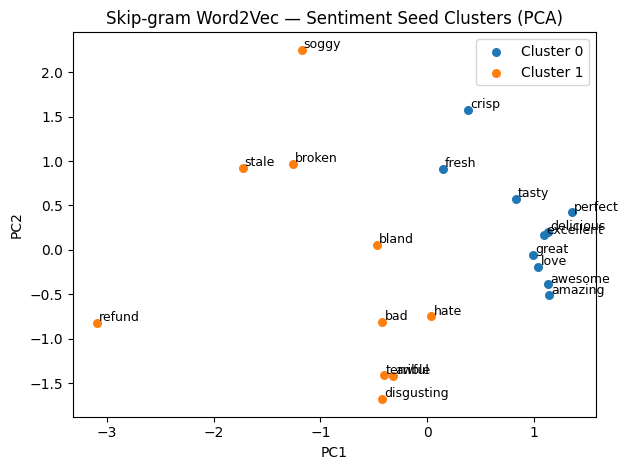


Step 4 complete — Word2Vec SG & CBOW trained; similarity, analogies, and clustering done (username-safe).


In [4]:




import os, re, warnings, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


!pip -q install gensim

from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


SEED = 42
random.seed(SEED)
np.random.seed(SEED)


def mask_path(path_str: str) -> str:
    home = os.path.expanduser("~")
    norm_path = os.path.normpath(path_str)
    norm_home = os.path.normpath(home)
    if norm_path.lower().startswith(norm_home.lower()):
        return norm_path.replace(home, "<HOME>")
    return norm_path


def first_existing_path(candidates):
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(
        "Cannot find corpus CSV. Provide one of: 'processed/amazon_reviews_clean.csv' "
        "or use the Step 2 split files as fallback."
    )


CLEAN_PATH = first_existing_path([
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin  NLP", "processed", "amazon_reviews_clean.csv"),
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin_NLP", "processed", "amazon_reviews_clean.csv"),
    os.path.join("processed", "amazon_reviews_clean.csv"),
    "amazon_reviews_clean.csv",
])

project_root = os.path.abspath(os.path.join(os.path.dirname(CLEAN_PATH), os.pardir))
processed_dir = os.path.join(project_root, "processed")
os.makedirs(processed_dir, exist_ok=True)


df = pd.read_csv(CLEAN_PATH, low_memory=False)

texts = (
    df["Summary"].fillna("").astype(str).str.strip() + " " +
    df["Text"].fillna("").astype(str).str.strip()
).str.replace(r"\s+", " ", regex=True)

print(f"Loaded corpus rows: {len(texts):,}")
print(f"Using cleaned file: {mask_path(CLEAN_PATH)}")


TOKEN_RE = re.compile(r"[a-z]{2,}")  
STOPWORDS = {
    "a","an","the","and","or","but","if","while","with","without","for","to","from",
    "of","in","on","at","by","about","as","into","through","over","after","before",
    "between","out","against","during","within","along","across",
    "is","am","are","was","were","be","been","being","do","does","did","doing",
    "have","has","had","having","i","me","my","we","our","you","your","he","him",
    "his","she","her","it","its","they","them","their","this","that","these","those",
    "there","here","not","no","nor","only","own","same","so","than","too","very",
    "can","will","just","don","should","now","because","what","which","who","whom",
    "why","how","when","where","all","any","both","each","few","more","most",
    "other","some","such"
}

def clean_for_w2v(s: str) -> list:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)   # keep digits; may help for '10/pack' etc.
    toks = TOKEN_RE.findall(s)
    toks = [t for t in toks if t not in STOPWORDS]
    return toks


sentences = [clean_for_w2v(t) for t in texts]
print("Tokenisation complete.")

# -----------------------------
# Train TWO Word2Vec models: Skip-gram and CBOW
# -----------------------------
# Common hyperparameters: reasonable for medium/large corpora
W2V_PARAMS = dict(
    vector_size=200,   # embedding dimension
    window=5,          # context window
    min_count=5,       # ignore rare words; adjust to 2 if you need more vocab
    workers=4,         # adjust to your CPU cores
    negative=10,       # negative sampling
    sample=1e-3,       # subsampling frequent words
    epochs=5,          # increase to 10 for better quality (more time)
    seed=SEED,
)

print("Training Skip-gram (sg=1)...")
w2v_sg = Word2Vec(sentences=sentences, sg=1, **W2V_PARAMS)

print("Training CBOW (sg=0)...")
w2v_cbow = Word2Vec(sentences=sentences, sg=0, **W2V_PARAMS)


kv_sg: KeyedVectors = w2v_sg.wv
kv_cbow: KeyedVectors = w2v_cbow.wv


PATH_W2V_SG = os.path.join(processed_dir, "w2v_skipgram.model")
PATH_W2V_CB = os.path.join(processed_dir, "w2v_cbow.model")
PATH_KV_SG  = os.path.join(processed_dir, "w2v_skipgram.kv")
PATH_KV_CB  = os.path.join(processed_dir, "w2v_cbow.kv")

w2v_sg.save(PATH_W2V_SG); w2v_cbow.save(PATH_W2V_CB)
kv_sg.save(PATH_KV_SG);   kv_cbow.save(PATH_KV_CB)

print("Models saved:")
print("  Skip-gram model :", mask_path(PATH_W2V_SG))
print("  CBOW model      :", mask_path(PATH_W2V_CB))
print("  Skip-gram KV    :", mask_path(PATH_KV_SG))
print("  CBOW KV         :", mask_path(PATH_KV_CB))

# -----------------------------
# Semantic Similarity (Cosine)
# -----------------------------
def safe_similarity(kv: KeyedVectors, w1: str, w2: str):
    w1, w2 = w1.lower(), w2.lower()
    if w1 in kv.key_to_index and w2 in kv.key_to_index:
        v = cosine_similarity([kv[w1]], [kv[w2]])[0,0]
        return float(v)
    return None

pairs_to_check = [
    ("good", "great"),
    ("good", "bad"),
    ("delicious", "tasty"),
    ("fresh", "stale"),
    ("cheap", "expensive"),
]

def print_similarity_report(name, kv):
    print(f"\n--- Cosine similarity ({name}) ---")
    for a, b in pairs_to_check:
        sim = safe_similarity(kv, a, b)
        if sim is None:
            print(f"{a:>10s} ~ {b:<10s} : OOV")
        else:
            print(f"{a:>10s} ~ {b:<10s} : {sim:.4f}")

print_similarity_report("Skip-gram", kv_sg)
print_similarity_report("CBOW", kv_cbow)

# -----------------------------
# Top-N Most Similar (qualitative inspection)
# -----------------------------
seed_words = ["delicious", "awful", "fresh", "stale", "quality", "refund", "packaging", "coffee", "tea"]
TOPN = 10

def safe_most_similar(kv: KeyedVectors, word: str, topn=10):
    w = word.lower()
    if w in kv.key_to_index:
        return kv.most_similar(w, topn=topn)
    return None

def export_most_similar_table(kv, name):
    rows = []
    for w in seed_words:
        res = safe_most_similar(kv, w, topn=TOPN)
        if res:
            for nbr, score in res:
                rows.append((w, nbr, float(score)))
        else:
            rows.append((w, "<OOV>", np.nan))
    out = pd.DataFrame(rows, columns=["seed_word", "neighbor", "similarity"])
    path = os.path.join(processed_dir, f"most_similar_{name}.csv")
    out.to_csv(path, index=False)
    print(f"\nSaved Top-{TOPN} neighbors table for {name}: {mask_path(path)}")
    return out

_ = export_most_similar_table(kv_sg, "skipgram")
_ = export_most_similar_table(kv_cbow, "cbow")

# -----------------------------
# Mini-Experiment 1: Analogies
# -----------------------------
# Format: a - b + c ≈ ?
analogies = [
    ("coffee", "caffeine", "tea"),           # coffee - caffeine + tea ≈ ?
    ("sugar", "sweet", "salt"),              # sugar - sweet + salt ≈ ?
    ("package", "box", "bottle"),            # package - box + bottle ≈ ?
    ("delicious", "tasty", "awful"),         # delicious - tasty + awful ≈ ?
    ("strong", "weak", "bold"),              # strong - weak + bold ≈ ?
]

def try_analogy(kv: KeyedVectors, a, b, c, topn=5):
    a, b, c = a.lower(), b.lower(), c.lower()
    for w in [a, b, c]:
        if w not in kv.key_to_index:
            return f"{a} - {b} + {c} : OOV"
    res = kv.most_similar(positive=[a, c], negative=[b], topn=topn)
    return [(w, float(s)) for (w, s) in res]

def run_analogies(kv, name):
    print(f"\n--- Analogies ({name}) ---")
    for a, b, c in analogies:
        ans = try_analogy(kv, a, b, c, topn=5)
        print(f"{a} - {b} + {c} -> {ans}")

run_analogies(kv_sg, "Skip-gram")
run_analogies(kv_cbow, "CBOW")

# -----------------------------
# Mini-Experiment 2: Clustering (sentiment seeds)
# -----------------------------
sentiment_seeds_pos = ["excellent","great","amazing","delicious","fresh","crisp","tasty","love","perfect","awesome"]
sentiment_seeds_neg = ["awful","terrible","bad","stale","soggy","bland","hate","refund","broken","disgusting"]
sentiment_seeds = sentiment_seeds_pos + sentiment_seeds_neg

def available_words(kv, words):
    return [w for w in words if w in kv.key_to_index]

avail_sg = available_words(kv_sg, sentiment_seeds)
if len(avail_sg) >= 6:  # ensure enough points for clustering
    X = np.vstack([kv_sg[w] for w in avail_sg])
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=SEED)
    labels = kmeans.fit_predict(X)

    # Save clustering table
    cluster_df = pd.DataFrame({"word": avail_sg, "cluster": labels})
    path_cluster = os.path.join(processed_dir, "w2v_skipgram_sentiment_clusters.csv")
    cluster_df.to_csv(path_cluster, index=False)
    print(f"\nSaved Skip-gram clustering table: {mask_path(path_cluster)}")

    # PCA for 2D visualisation
    pca = PCA(n_components=2, random_state=SEED)
    coords = pca.fit_transform(X)
    plt.figure()
    for cl in [0,1]:
        idx = np.where(labels == cl)[0]
        plt.scatter(coords[idx,0], coords[idx,1], label=f"Cluster {cl}", s=30)
        for j in idx:
            plt.text(coords[j,0]+0.02, coords[j,1]+0.02, avail_sg[j], fontsize=9)
    plt.title("Skip-gram Word2Vec — Sentiment Seed Clusters (PCA)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("\nNot enough sentiment seeds found in vocab for clustering (Skip-gram). Try lowering min_count or adjusting seeds.")

print("\nStep 4 complete — Word2Vec SG & CBOW trained; similarity, analogies, and clustering done (username-safe).")






## Step 4.1 — Keyword schema + labels (multi-label ground truth)



In [5]:


import os, re, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

def mask_path(p):
    import os
    home = os.path.expanduser("~")
    np_ = os.path.normpath(p); nh = os.path.normpath(home)
    return np_.replace(home, "<HOME>") if np_.lower().startswith(nh.lower()) else np_

def first_existing_path(cands):
    import os
    for p in cands:
        if os.path.exists(p): return p
    raise FileNotFoundError("Cannot find split CSVs; check your processed folder.")

BASE = first_existing_path([
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin  NLP", "processed"),
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin_NLP", "processed"),
    "processed"
])

paths = {
    "train": os.path.join(BASE, "reviews_train_2cls.csv"),
    "val":   os.path.join(BASE, "reviews_val_2cls.csv"),
    "test":  os.path.join(BASE, "reviews_test_2cls.csv"),
}
print("Using:", {k: mask_path(v) for k, v in paths.items()})


def combine_text(df):
    s = (df["Summary"].fillna("").astype(str).str.strip() + " " +
         df["Text"].fillna("").astype(str).str.strip())
    return s.str.replace(r"\s+", " ", regex=True).str.lower()

train = pd.read_csv(paths["train"]); val = pd.read_csv(paths["val"]); test = pd.read_csv(paths["test"])
Xtr, Xva, Xte = combine_text(train), combine_text(val), combine_text(test)


KEYWORDS = [
    "taste","flavor","smell","aroma","fresh","stale","price","packaging",
    "delivery","quality","texture","size","coffee","tea","chocolate"
]


def mk_pattern(w):

    if w.endswith("e"):
        return re.compile(rf"\b{re.escape(w)}(s|d)?\b", re.I)
    return re.compile(rf"\b{re.escape(w)}(s)?\b", re.I)

PATTERNS = {w: mk_pattern(w) for w in KEYWORDS}

def build_Y(series):
    Y = {}
    for w, pat in PATTERNS.items():
        Y[w] = series.apply(lambda t: int(bool(pat.search(t))))
    return pd.DataFrame(Y, index=series.index)

Ytr, Yva, Yte = build_Y(Xtr), build_Y(Xva), build_Y(Xte)


Y_paths = {
    "train": os.path.join(BASE, "labels_keywords_train.csv"),
    "val":   os.path.join(BASE, "labels_keywords_val.csv"),
    "test":  os.path.join(BASE, "labels_keywords_test.csv"),
}
Ytr.to_csv(Y_paths["train"], index=False)
Yva.to_csv(Y_paths["val"], index=False)
Yte.to_csv(Y_paths["test"], index=False)

print("Keyword label files saved:")
for k, v in Y_paths.items(): print(f"  {k}: {mask_path(v)}")

print("\nLabel prevalence (train):")
print(Ytr.mean().sort_values(ascending=False).round(4).to_string())



Using: {'train': '<HOME>\\Downloads\\Sachin  NLP\\processed\\reviews_train_2cls.csv', 'val': '<HOME>\\Downloads\\Sachin  NLP\\processed\\reviews_val_2cls.csv', 'test': '<HOME>\\Downloads\\Sachin  NLP\\processed\\reviews_test_2cls.csv'}
Keyword label files saved:
  train: <HOME>\Downloads\Sachin  NLP\processed\labels_keywords_train.csv
  val: <HOME>\Downloads\Sachin  NLP\processed\labels_keywords_val.csv
  test: <HOME>\Downloads\Sachin  NLP\processed\labels_keywords_test.csv

Label prevalence (train):
taste        0.3032
flavor       0.2276
price        0.1327
coffee       0.1302
tea          0.0978
chocolate    0.0617
quality      0.0582
size         0.0494
fresh        0.0494
smell        0.0417
texture      0.0368
packaging    0.0252
aroma        0.0153
delivery     0.0151
stale        0.0094




## Step 4.2 — Classical IE: TF-IDF + One-vs-Rest Logistic Regression (multi-label)



In [6]:



import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

def mask_path(p):
    import os
    home = os.path.expanduser("~")
    np_ = os.path.normpath(p); nh = os.path.normpath(home)
    return np_.replace(home, "<HOME>") if np_.lower().startswith(nh.lower()) else np_

BASE = None
for p in [
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin  NLP", "processed"),
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin_NLP", "processed"),
    "processed"
]:
    if os.path.exists(p): BASE = p; break
assert BASE is not None

# Load splits + labels created in 3.6
train = pd.read_csv(os.path.join(BASE, "reviews_train_2cls.csv"))
val   = pd.read_csv(os.path.join(BASE, "reviews_val_2cls.csv"))
test  = pd.read_csv(os.path.join(BASE, "reviews_test_2cls.csv"))

Ytr = pd.read_csv(os.path.join(BASE, "labels_keywords_train.csv"))
Yva = pd.read_csv(os.path.join(BASE, "labels_keywords_val.csv"))
Yte = pd.read_csv(os.path.join(BASE, "labels_keywords_test.csv"))

KEYWORDS = list(Ytr.columns)

def combine_text(df):
    s = (df["Summary"].fillna("").astype(str).str.strip() + " " +
         df["Text"].fillna("").astype(str).str.strip())
    return s.str.replace(r"\s+", " ", regex=True)

Xtr = combine_text(train); Xva = combine_text(val); Xte = combine_text(test)

# Vectoriser
tfidf = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9,
    strip_accents="ascii",
    sublinear_tf=True
)

Xtr_vec = tfidf.fit_transform(Xtr)
Xva_vec = tfidf.transform(Xva)
Xte_vec = tfidf.transform(Xte)


base_lr = LogisticRegression(
    solver="saga", penalty="l2", C=1.0, max_iter=2000, n_jobs=-1
)
clf = OneVsRestClassifier(base_lr)

clf.fit(Xtr_vec, Ytr.values)

def eval_print(name, Xv, Yv, labels):
    Y_pred = clf.predict(Xv)
    print(f"\n=== Classical IE ({name}) — per-label metrics ===")
    print(classification_report(Yv, Y_pred, target_names=labels, digits=4, zero_division=0))
    # micro/macro summary
    from sklearn.metrics import f1_score, precision_score, recall_score
    print("Summary:")
    print("  micro  P/R/F1:", 
          precision_score(Yv, Y_pred, average="micro", zero_division=0),
          recall_score(Yv, Y_pred, average="micro", zero_division=0),
          f1_score(Yv, Y_pred, average="micro", zero_division=0))
    print("  macro  P/R/F1:", 
          precision_score(Yv, Y_pred, average="macro", zero_division=0),
          recall_score(Yv, Y_pred, average="macro", zero_division=0),
          f1_score(Yv, Y_pred, average="macro", zero_division=0))

eval_print("VAL", Xva_vec, Yva.values, KEYWORDS)
eval_print("TEST", Xte_vec, Yte.values, KEYWORDS)


import joblib
ART = {
    "vectorizer": os.path.join(BASE, "ie_keywords_tfidf_vectorizer.joblib"),
    "classifier": os.path.join(BASE, "ie_keywords_ovr_logreg.joblib"),
}
joblib.dump(tfidf, ART["vectorizer"])
joblib.dump(clf, ART["classifier"])
print("\nArtifacts saved:")
for k,v in ART.items(): print(f"  {k}: {mask_path(v)}")





=== Classical IE (VAL) — per-label metrics ===
              precision    recall  f1-score   support

       taste     1.0000    0.9975    0.9987      3973
      flavor     1.0000    0.9964    0.9982      3032
       smell     1.0000    0.9052    0.9503       517
       aroma     1.0000    0.8241    0.9036       199
       fresh     1.0000    0.9666    0.9830       629
       stale     1.0000    0.6880    0.8152       125
       price     1.0000    0.9695    0.9845      1739
   packaging     1.0000    0.8991    0.9469       327
    delivery     1.0000    0.8090    0.8944       178
     quality     1.0000    0.9585    0.9788       771
     texture     1.0000    0.9099    0.9528       433
        size     1.0000    0.9127    0.9544       630
      coffee     0.9994    0.9706    0.9848      1701
         tea     1.0000    0.9621    0.9807      1293
   chocolate     1.0000    0.9617    0.9805       810

   micro avg     0.9999    0.9669    0.9832     16357
   macro avg     1.0000    0.915



# Step 5 — Transformer IE: DistilBERT multi-label (no-Trainer)



In [7]:



import os, warnings, numpy as np, torch, time
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
warnings.filterwarnings("ignore")

def mask_path(p):
    home = os.path.expanduser("~"); import os
    np_ = os.path.normpath(p); nh = os.path.normpath(home)
    return np_.replace(home, "<HOME>") if np_.lower().startswith(nh.lower()) else np_

# Paths & data
BASE = None
for p in [
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin  NLP", "processed"),
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin_NLP", "processed"),
    "processed"
]:
    if os.path.exists(p): BASE = p; break
assert BASE is not None
train = pd.read_csv(os.path.join(BASE, "reviews_train_2cls.csv"))
val   = pd.read_csv(os.path.join(BASE, "reviews_val_2cls.csv"))
test  = pd.read_csv(os.path.join(BASE, "reviews_test_2cls.csv"))
Ytr = pd.read_csv(os.path.join(BASE, "labels_keywords_train.csv")); KEYWORDS = list(Ytr.columns)
Yva = pd.read_csv(os.path.join(BASE, "labels_keywords_val.csv"))
Yte = pd.read_csv(os.path.join(BASE, "labels_keywords_test.csv"))

def combine_text(df):
    s = (df["Summary"].fillna("").astype(str).str.strip() + " " +
         df["Text"].fillna("").astype(str).str.strip())
    return s.str.replace(r"\s+", " ", regex=True)

Xtr = combine_text(train); Xva = combine_text(val); Xte = combine_text(test)


MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 256

def enc(texts):
    return tokenizer(texts.tolist(), truncation=True, padding=True, max_length=MAX_LEN)

enc_tr = enc(Xtr); enc_va = enc(Xva); enc_te = enc(Xte)

class DS(Dataset):
    def __init__(self, enc, Y): self.enc, self.Y = enc, torch.tensor(Y.values, dtype=torch.float32)
    def __len__(self): return len(self.Y)
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k,v in self.enc.items()}
        item["labels"] = self.Y[i]
        return item

ds_tr, ds_va, ds_te = DS(enc_tr, Ytr), DS(enc_va, Yva), DS(enc_te, Yte)


num_labels = len(KEYWORDS)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_labels, problem_type="multi_label_classification"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BATCH = 16
EPOCHS = 2
opt = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

tr_loader = DataLoader(ds_tr, batch_size=BATCH, shuffle=True, pin_memory=(device.type=="cuda"))
va_loader = DataLoader(ds_va, batch_size=BATCH, shuffle=False, pin_memory=(device.type=="cuda"))
te_loader = DataLoader(ds_te, batch_size=BATCH, shuffle=False, pin_memory=(device.type=="cuda"))

total_steps = EPOCHS * len(tr_loader)
sched = get_linear_schedule_with_warmup(opt, int(0.06*total_steps), total_steps)

def eval_loop(loader, name):
    model.eval()
    logits, labels = [], []
    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(device); attn = batch["attention_mask"].to(device)
            y = batch["labels"].to(device)
            out = model(input_ids=ids, attention_mask=attn)
            logits.append(out.logits.detach().cpu()); labels.append(y.detach().cpu())
    L = torch.cat(labels).numpy(); Z = torch.cat(logits).numpy()
    P = (1/(1+np.exp(-Z))) >= 0.5  # sigmoid threshold 0.5
    print(f"\n=== Transformer IE ({name}) — per-label metrics ===")
    print(classification_report(L, P, target_names=KEYWORDS, digits=4, zero_division=0))
    print("Summary:")
    print("  micro  P/R/F1:", precision_score(L, P, average="micro", zero_division=0),
          recall_score(L, P, average="micro", zero_division=0),
          f1_score(L, P, average="micro", zero_division=0))
    print("  macro  P/R/F1:", precision_score(L, P, average="macro", zero_division=0),
          recall_score(L, P, average="macro", zero_division=0),
          f1_score(L, P, average="macro", zero_division=0))
    return f1_score(L, P, average="micro", zero_division=0)

best = -1.0; best_state = None
for ep in range(1, EPOCHS+1):
    model.train(); running = 0.0; t0 = time.time()
    for step, batch in enumerate(tr_loader, 1):
        ids = batch["input_ids"].to(device); attn = batch["attention_mask"].to(device)
        y = batch["labels"].to(device)
        out = model(input_ids=ids, attention_mask=attn, labels=y)  # BCEWithLogitsLoss applied
        loss = out.loss
        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step(); sched.step()
        running += float(loss.item())
        if step % 100 == 0:
            print(f"Epoch {ep} [{step}/{len(tr_loader)}] Loss: {running/step:.4f}", end="\r")
    print(f"\nEpoch {ep} finished in {time.time()-t0:.1f}s | Train loss: {running/len(tr_loader):.4f}")
    micro_f1 = eval_loop(va_loader, "VAL")
    if micro_f1 > best:
        best = micro_f1
        best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
        print(f"-> New best VAL micro-F1: {best:.4f}")

if best_state is not None:
    model.load_state_dict(best_state)

save_dir = os.path.join(BASE, "distilbert_ie_keywords")
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir); tokenizer.save_pretrained(save_dir)
print("\nTransformer IE model saved to:", mask_path(save_dir))

_ = eval_loop(va_loader, "VAL (Best)")
_ = eval_loop(te_loader, "TEST")




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 [26200/26291] Loss: 0.0300
Epoch 1 finished in 9076.5s | Train loss: 0.0299

=== Transformer IE (VAL) — per-label metrics ===
              precision    recall  f1-score   support

       taste     0.9990    0.9844    0.9916      3973
      flavor     0.9970    0.9825    0.9897      3032
       smell     1.0000    0.9613    0.9803       517
       aroma     1.0000    0.9497    0.9742       199
       fresh     1.0000    0.9555    0.9772       629
       stale     1.0000    0.9360    0.9669       125
       price     0.9994    0.9620    0.9804      1739
   packaging     0.9937    0.9602    0.9767       327
    delivery     1.0000    0.9831    0.9915       178
     quality     0.9973    0.9494    0.9728       771
     texture     1.0000    0.9584    0.9788       433
        size     1.0000    0.9524    0.9756       630
      coffee     1.0000    0.9871    0.9935      1701
         tea     1.0000    0.9899    0.9949      1293
   chocolate     1.0000    0.9827    0.9913       810



UnboundLocalError: cannot access local variable 'os' where it is not associated with a value

In [8]:



import os
import numpy as np

def mask_path(p: str) -> str:
    home = os.path.expanduser("~")
    p_norm = os.path.normpath(p)
    home_norm = os.path.normpath(home)
    return p_norm.replace(home, "<HOME>") if p_norm.lower().startswith(home_norm.lower()) else p_norm


save_dir = os.path.join(BASE, "distilbert_ie_keywords")
print("\nTransformer IE model saved to:", mask_path(save_dir))


_ = eval_loop(va_loader, "VAL (Best)")
_ = eval_loop(te_loader, "TEST")





Transformer IE model saved to: <HOME>\Downloads\Sachin  NLP\processed\distilbert_ie_keywords

=== Transformer IE (VAL (Best)) — per-label metrics ===
              precision    recall  f1-score   support

       taste     0.9967    0.9889    0.9928      3973
      flavor     0.9983    0.9828    0.9905      3032
       smell     1.0000    0.9691    0.9843       517
       aroma     1.0000    0.9548    0.9769       199
       fresh     0.9983    0.9603    0.9789       629
       stale     1.0000    0.9520    0.9754       125
       price     1.0000    0.9666    0.9830      1739
   packaging     0.9905    0.9602    0.9752       327
    delivery     1.0000    0.9831    0.9915       178
     quality     0.9986    0.9572    0.9775       771
     texture     1.0000    0.9584    0.9788       433
        size     1.0000    0.9571    0.9781       630
      coffee     0.9994    0.9871    0.9932      1701
         tea     0.9992    0.9915    0.9953      1293
   chocolate     1.0000    0.9852    0


## STEP 5.1 — Threshold tuning on VAL + Final eval + Artifact saves



Chosen global threshold (by VAL micro-F1): 0.60 (VAL micro-F1=0.9886)

=== Transformer IE (VAL (global t)) — per-label metrics ===
              precision    recall  f1-score   support

       taste     0.9985    0.9879    0.9932      3973
      flavor     0.9987    0.9825    0.9905      3032
       smell     1.0000    0.9691    0.9843       517
       aroma     1.0000    0.9548    0.9769       199
       fresh     1.0000    0.9603    0.9797       629
       stale     1.0000    0.9520    0.9754       125
       price     1.0000    0.9666    0.9830      1739
   packaging     0.9905    0.9602    0.9752       327
    delivery     1.0000    0.9831    0.9915       178
     quality     0.9986    0.9572    0.9775       771
     texture     1.0000    0.9584    0.9788       433
        size     1.0000    0.9571    0.9781       630
      coffee     1.0000    0.9871    0.9935      1701
         tea     0.9992    0.9915    0.9953      1293
   chocolate     1.0000    0.9840    0.9919       810

   

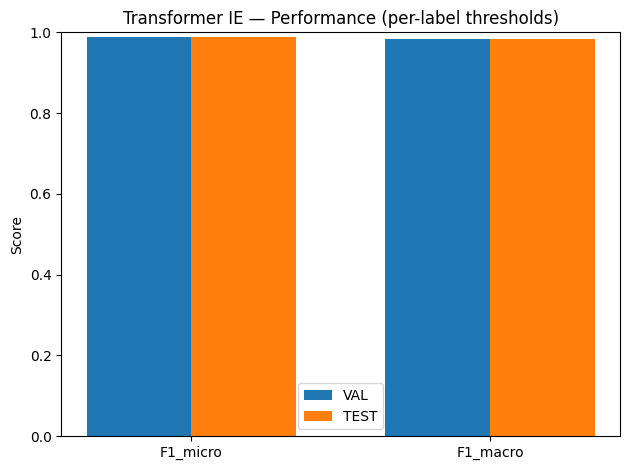

In [9]:




import os, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def mask_path(p: str) -> str:
    home = os.path.expanduser("~")
    p_norm = os.path.normpath(p)
    home_norm = os.path.normpath(home)
    return p_norm.replace(home, "<HOME>") if p_norm.lower().startswith(home_norm.lower()) else p_norm

assert 'model' in globals() and 'va_loader' in globals() and 'te_loader' in globals() and 'KEYWORDS' in globals()
device = next(model.parameters()).device

def collect_logits_labels(loader):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            ids  = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            y    = batch["labels"].to(device)
            out  = model(input_ids=ids, attention_mask=attn)
            all_logits.append(out.logits.detach().cpu()); all_labels.append(y.detach().cpu())
    Z = torch.cat(all_logits).numpy()
    L = torch.cat(all_labels).numpy()
    P = 1.0 / (1.0 + np.exp(-Z))  
    return P, L

# 1) Gather probabilities on VAL/TEST 
P_val, L_val = collect_logits_labels(va_loader)
P_test, L_test = collect_logits_labels(te_loader)

# 2) Tune thresholds on VAL
def tune_global_threshold(P, L, grid=np.linspace(0.2, 0.8, 13)):
    best_t, best_micro = 0.5, -1.0
    for t in grid:
        pred = (P >= t).astype(int)
        f1_micro = f1_score(L, pred, average="micro", zero_division=0)
        if f1_micro > best_micro:
            best_micro, best_t = f1_micro, t
    return best_t, best_micro

def tune_per_label_thresholds(P, L, grid=np.linspace(0.2, 0.8, 13)):
    T = np.full(P.shape[1], 0.5, dtype=float)
    for j in range(P.shape[1]):
        best_t, best_f1 = 0.5, -1.0
        col = P[:, j]
        yj  = L[:, j]
        for t in grid:
            pred_col = (col >= t).astype(int)
            f1_col = f1_score(yj, pred_col, average="binary", zero_division=0)
            if f1_col > best_f1:
                best_f1, best_t = f1_col, t
        T[j] = best_t
    return T

t_global, f1g = tune_global_threshold(P_val, L_val)
T_perlabel = tune_per_label_thresholds(P_val, L_val)
print(f"Chosen global threshold (by VAL micro-F1): {t_global:.2f} (VAL micro-F1={f1g:.4f})")

# 3) Evaluate helper
def eval_with_thresholds(P, L, thresholds, labels, name="TEST"):
    if np.ndim(thresholds) == 0:
        pred = (P >= thresholds).astype(int)
    else:
        pred = (P >= thresholds[None, :]).astype(int)

    print(f"\n=== Transformer IE ({name}) — per-label metrics ===")
    print(classification_report(L, pred, target_names=labels, digits=4, zero_division=0))
    p_micro = precision_score(L, pred, average="micro", zero_division=0)
    r_micro = recall_score(L, pred, average="micro", zero_division=0)
    f_micro = f1_score(L, pred, average="micro", zero_division=0)
    p_macro = precision_score(L, pred, average="macro", zero_division=0)
    r_macro = recall_score(L, pred, average="macro", zero_division=0)
    f_macro = f1_score(L, pred, average="macro", zero_division=0)
    print("Summary:")
    print("  micro  P/R/F1:", p_micro, r_micro, f_micro)
    print("  macro  P/R/F1:", p_macro, r_macro, f_macro)
    return {"p_micro": p_micro, "r_micro": r_micro, "f_micro": f_micro,
            "p_macro": p_macro, "r_macro": r_macro, "f_macro": f_macro, "pred": pred}

# 4) Evaluate on VAL/TEST with global and per-label thresholds
res_val_global  = eval_with_thresholds(P_val,  L_val,  t_global,  KEYWORDS, name="VAL (global t)")
res_val_perlab  = eval_with_thresholds(P_val,  L_val,  T_perlabel, KEYWORDS, name="VAL (per-label t)")
res_test_global = eval_with_thresholds(P_test, L_test, t_global,  KEYWORDS, name="TEST (global t)")
res_test_perlab = eval_with_thresholds(P_test, L_test, T_perlabel, KEYWORDS, name="TEST (per-label t)")

# 5) Persist artifacts (thresholds + predictions) 
assert 'save_dir' in globals(), "save_dir not found; it should be the DistilBERT IE model folder."
out_dir = os.path.join(save_dir, "eval_artifacts")
os.makedirs(out_dir, exist_ok=True)

np.save(os.path.join(out_dir, "threshold_global.npy"), np.array([t_global]))
np.save(os.path.join(out_dir, "thresholds_per_label.npy"), T_perlabel)

pd.DataFrame({"label": KEYWORDS, "threshold_per_label": T_perlabel}) \
  .to_csv(os.path.join(out_dir, "thresholds_per_label.csv"), index=False)

summary = pd.DataFrame([
    {"split": "VAL",  "mode": "global",   "p_micro":res_val_global["p_micro"],  "r_micro":res_val_global["r_micro"],  "f_micro":res_val_global["f_micro"],
                                         "p_macro":res_val_global["p_macro"],  "r_macro":res_val_global["r_macro"],  "f_macro":res_val_global["f_macro"]},
    {"split": "VAL",  "mode": "perlabel", "p_micro":res_val_perlab["p_micro"],  "r_micro":res_val_perlab["r_micro"],  "f_micro":res_val_perlab["f_micro"],
                                         "p_macro":res_val_perlab["p_macro"],  "r_macro":res_val_perlab["r_macro"],  "f_macro":res_val_perlab["f_macro"]},
    {"split": "TEST", "mode": "global",   "p_micro":res_test_global["p_micro"], "r_micro":res_test_global["r_micro"], "f_micro":res_test_global["f_micro"],
                                         "p_macro":res_test_global["p_macro"], "r_macro":res_test_global["r_macro"], "f_macro":res_test_global["f_macro"]},
    {"split": "TEST", "mode": "perlabel", "p_micro":res_test_perlab["p_micro"], "r_micro":res_test_perlab["r_micro"], "f_micro":res_test_perlab["f_micro"],
                                         "p_macro":res_test_perlab["p_macro"], "r_macro":res_test_perlab["r_macro"], "f_macro":res_test_perlab["f_macro"]},
])
summary_path = os.path.join(out_dir, "transformer_ie_summary.csv")
summary.to_csv(summary_path, index=False)

print("\nArtifacts saved:")
print("  thresholds (global):     ", mask_path(os.path.join(out_dir, "threshold_global.npy")))
print("  thresholds (per-label):  ", mask_path(os.path.join(out_dir, "thresholds_per_label.csv")))
print("  summary CSV:             ", mask_path(summary_path))

# 6) Quick visual (VAL vs TEST, per-label thresholds)
labels_plot = ["F1_micro","F1_macro"]
VAL = [res_val_perlab["f_micro"], res_val_perlab["f_macro"]]
TST = [res_test_perlab["f_micro"], res_test_perlab["f_macro"]]
x = np.arange(len(labels_plot)); w = 0.35
plt.figure()
plt.bar(x - w/2, VAL, w, label="VAL")
plt.bar(x + w/2, TST, w, label="TEST")
plt.xticks(x, labels_plot)
plt.ylim(0, 1.0)
plt.title("Transformer IE — Performance (per-label thresholds)")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()





# STEP 6 — Classical vs Transformer IE: side-by-side comparison (VAL & TEST)




=== Classical vs Transformer IE — Summary ===
split   metric  Classical  Transformer
  VAL F1_micro   0.983154     0.988924
  VAL F1_macro   0.953781     0.984703
 TEST F1_micro   0.983323     0.988453
 TEST F1_macro   0.957250     0.984274


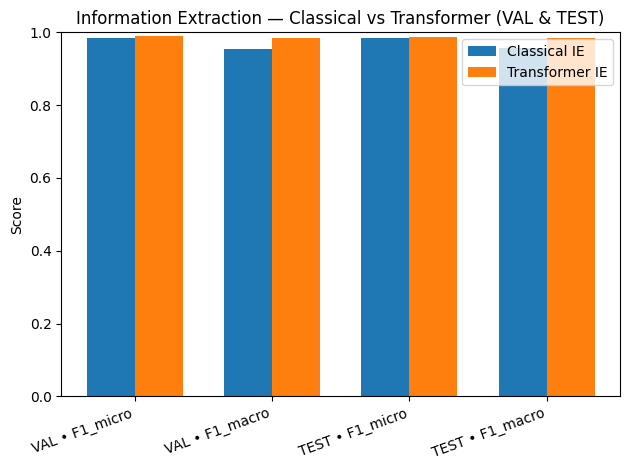


Saved comparison CSV to: <HOME>\Downloads\Sachin  NLP\processed\ie_classical_vs_transformer_summary.csv
Vectorizer: <HOME>\Downloads\Sachin  NLP\processed\ie_keywords_tfidf_vectorizer.joblib
Classifier: <HOME>\Downloads\Sachin  NLP\processed\ie_keywords_ovr_logreg.joblib
Transformer summary: <HOME>\Downloads\Sachin  NLP\processed\distilbert_ie_keywords\eval_artifacts\transformer_ie_summary.csv


In [11]:




import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import joblib



def mask_path(p: str) -> str:
    """Shorten home-directory paths for neat printing."""
    home = os.path.expanduser("~")
    np_ = os.path.normpath(p)
    nh = os.path.normpath(home)
    return np_.replace(home, "<HOME>") if np_.lower().startswith(nh.lower()) else np_

# --- Locate processed base ---
BASE = None
for p in [
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin  NLP", "processed"),
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin_NLP", "processed"),
    "processed"
]:
    if os.path.exists(p): BASE = p; break
assert BASE is not None, "processed folder not found."

# --- Load splits + keyword labels ---
train = pd.read_csv(os.path.join(BASE, "reviews_train_2cls.csv"))
val   = pd.read_csv(os.path.join(BASE, "reviews_val_2cls.csv"))
test  = pd.read_csv(os.path.join(BASE, "reviews_test_2cls.csv"))
Yva   = pd.read_csv(os.path.join(BASE, "labels_keywords_val.csv"))
Yte   = pd.read_csv(os.path.join(BASE, "labels_keywords_test.csv"))
KEYWORDS = list(Yva.columns)

def combine_text(df):
    s = (df["Summary"].fillna("").astype(str).str.strip() + " " +
         df["Text"].fillna("").astype(str).str.strip())
    return s.str.replace(r"\s+", " ", regex=True)

Xva = combine_text(val)
Xte = combine_text(test)

# --- Load classical IE artifacts and evaluate on VAL/TEST ---
vec_path = os.path.join(BASE, "ie_keywords_tfidf_vectorizer.joblib")
clf_path = os.path.join(BASE, "ie_keywords_ovr_logreg.joblib")
tfidf = joblib.load(vec_path)
clf   = joblib.load(clf_path)

Xva_vec = tfidf.transform(Xva)
Xte_vec = tfidf.transform(Xte)

Yva_pred = clf.predict(Xva_vec)
Yte_pred = clf.predict(Xte_vec)

def summarise(y_true, y_pred):
    return {
        "p_micro": precision_score(y_true, y_pred, average="micro", zero_division=0),
        "r_micro": recall_score( y_true, y_pred, average="micro", zero_division=0),
        "f_micro": f1_score(     y_true, y_pred, average="micro", zero_division=0),
        "p_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "r_macro": recall_score( y_true, y_pred, average="macro", zero_division=0),
        "f_macro": f1_score(     y_true, y_pred, average="macro", zero_division=0),
    }

cls_val  = summarise(Yva.values, Yva_pred)
cls_test = summarise(Yte.values, Yte_pred)

# --- Load Transformer IE summary you saved in Step 5.1 (per-label thresholds) ---
TR_DIR = os.path.join(BASE, "distilbert_ie_keywords", "eval_artifacts")
tr_sum_path = os.path.join(TR_DIR, "transformer_ie_summary.csv")
tr_sum = pd.read_csv(tr_sum_path)

def pick_row(split, mode):
    row = tr_sum[(tr_sum["split"]==split) & (tr_sum["mode"]==mode)].iloc[0]
    return {
        "p_micro": row["p_micro"], "r_micro": row["r_micro"], "f_micro": row["f_micro"],
        "p_macro": row["p_macro"], "r_macro": row["r_macro"], "f_macro": row["f_macro"],
    }

# use the stronger "perlabel" tuned thresholds for the transformer
tr_val  = pick_row("VAL",  "perlabel")
tr_test = pick_row("TEST", "perlabel")

# --- Assemble comparison table ---
rows = []
rows += [{"split":"VAL","metric":"F1_micro","Classical":cls_val["f_micro"],"Transformer":tr_val["f_micro"]}]
rows += [{"split":"VAL","metric":"F1_macro","Classical":cls_val["f_macro"],"Transformer":tr_val["f_macro"]}]
rows += [{"split":"TEST","metric":"F1_micro","Classical":cls_test["f_micro"],"Transformer":tr_test["f_micro"]}]
rows += [{"split":"TEST","metric":"F1_macro","Classical":cls_test["f_macro"],"Transformer":tr_test["f_macro"]}]
cmp_df = pd.DataFrame(rows)
print("\n=== Classical vs Transformer IE — Summary ===")
print(cmp_df.to_string(index=False))

# --- Bar plot for the report ---
plt.figure()
x = np.arange(len(cmp_df))
w = 0.35
plt.bar(x - w/2, cmp_df["Classical"], w, label="Classical IE")
plt.bar(x + w/2, cmp_df["Transformer"], w, label="Transformer IE")
plt.xticks(x, cmp_df["split"] + " • " + cmp_df["metric"], rotation=20, ha="right")
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Information Extraction — Classical vs Transformer (VAL & TEST)")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()


out_csv = os.path.join(BASE, "ie_classical_vs_transformer_summary.csv")
cmp_df.to_csv(out_csv, index=False)
print("\nSaved comparison CSV to:", mask_path(out_csv))
print("Vectorizer:", mask_path(vec_path))
print("Classifier:", mask_path(clf_path))
print("Transformer summary:", mask_path(tr_sum_path))







## Step 7A — ROC-AUC + Resource & Throughput



In [12]:



import os, time, warnings, numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
warnings.filterwarnings("ignore")

def _mask(p):
    home = os.path.expanduser("~"); pn=os.path.normpath(p); hn=os.path.normpath(home)
    return pn.replace(home, "<HOME>") if pn.lower().startswith(hn.lower()) else pn


BASE = None
for p in [
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin  NLP", "processed"),
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin_NLP", "processed"),
    "processed"
]:
    if os.path.exists(p): BASE=p; break
assert BASE is not None


import joblib
val   = pd.read_csv(os.path.join(BASE, "reviews_val_2cls.csv"))
test  = pd.read_csv(os.path.join(BASE, "reviews_test_2cls.csv"))
Yva   = pd.read_csv(os.path.join(BASE, "labels_keywords_val.csv"))
Yte   = pd.read_csv(os.path.join(BASE, "labels_keywords_test.csv"))
KEYWORDS = list(Yva.columns)

def combine_text(df):
    s = (df["Summary"].fillna("").astype(str).str.strip()+" "+df["Text"].fillna("").astype(str).str.strip())
    return s.str.replace(r"\s+", " ", regex=True)

Xva = combine_text(val)
Xte = combine_text(test)


vec_path = os.path.join(BASE, "ie_keywords_tfidf_vectorizer.joblib")
clf_path = os.path.join(BASE, "ie_keywords_ovr_logreg.joblib")
tfidf = joblib.load(vec_path)
clf   = joblib.load(clf_path)

t0 = time.time()
Xva_vec = tfidf.transform(Xva); Xte_vec = tfidf.transform(Xte)
vec_time_val = time.time()-t0; 
t1 = time.time()

if hasattr(clf, "decision_function"):
    S_val = clf.decision_function(Xva_vec); S_test = clf.decision_function(Xte_vec)
else:
    S_val = clf.predict_proba(Xva_vec);     S_test = clf.predict_proba(Xte_vec)
inf_time_val = time.time()-t1

roc_classical = {
    "VAL_micro": roc_auc_score(Yva.values, S_val, average="micro"),
    "VAL_macro": roc_auc_score(Yva.values, S_val, average="macro"),
    "TEST_micro": roc_auc_score(Yte.values, S_test, average="micro"),
    "TEST_macro": roc_auc_score(Yte.values, S_test, average="macro"),
}


try:
    P_val, P_test  # noqa
except NameError:
    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    MODEL_DIR = os.path.join(BASE, "distilbert_ie_keywords")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device); model.eval()

    def _enc(texts, max_len=256):
        return tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_len)
    enc_va = _enc(Xva); enc_te = _enc(Xte)
    import torch
    def _prob(enc):
        bs=16; logits=[]
        for i in range(0, len(enc["input_ids"]), bs):
            batch = {k: torch.tensor(v[i:i+bs]).to(device) for k,v in enc.items()}
            with torch.no_grad():
                out = model(**batch).logits.detach().cpu().numpy()
            logits.append(out)
        Z = np.vstack(logits)
        return 1/(1+np.exp(-Z))
    P_val = _prob(enc_va); P_test = _prob(enc_te)

roc_transformer = {
    "VAL_micro": roc_auc_score(Yva.values, P_val, average="micro"),
    "VAL_macro": roc_auc_score(Yva.values, P_val, average="macro"),
    "TEST_micro": roc_auc_score(Yte.values, P_test, average="micro"),
    "TEST_macro": roc_auc_score(Yte.values, P_test, average="macro"),
}


t2=time.time(); _=clf.predict(Xte_vec); pred_time = time.time()-t2
throughput_cls = len(Xte)/pred_time


cls_size_mb = os.path.getsize(clf_path)/1_048_576 + os.path.getsize(vec_path)/1_048_576

def _folder_size_mb(path):
    total=0
    for root, _, files in os.walk(path):
        for f in files:
            total += os.path.getsize(os.path.join(root,f))
    return total/1_048_576
tr_dir = os.path.join(BASE, "distilbert_ie_keywords")
tr_size_mb = _folder_size_mb(tr_dir)

summary_rows = [
    ["ROC-AUC micro (VAL)", roc_classical["VAL_micro"], roc_transformer["VAL_micro"]],
    ["ROC-AUC macro (VAL)", roc_classical["VAL_macro"], roc_transformer["VAL_macro"]],
    ["ROC-AUC micro (TEST)", roc_classical["TEST_micro"], roc_transformer["TEST_micro"]],
    ["ROC-AUC macro (TEST)", roc_classical["TEST_macro"], roc_transformer["TEST_macro"]],
    ["Throughput (test docs/sec, classical)", throughput_cls, None],
    ["Vectorise time (VAL) sec", vec_time_val, None],
    ["Infer time (VAL) sec (classical)", inf_time_val, None],
    ["Model size MB (classical total)", cls_size_mb, None],
    ["Model folder size MB (transformer)", None, tr_size_mb],
]

summary_df = pd.DataFrame(summary_rows, columns=["Metric","Classical","Transformer"])
out_csv = os.path.join(BASE, "metrics_rocauc_throughput_sizes.csv")
summary_df.to_csv(out_csv, index=False)
print(summary_df.to_string(index=False))
print("\nSaved:", _mask(out_csv))




                               Metric    Classical  Transformer
                  ROC-AUC micro (VAL)     0.999947     0.999728
                  ROC-AUC macro (VAL)     0.999957     0.999433
                 ROC-AUC micro (TEST)     0.999961     0.999747
                 ROC-AUC macro (TEST)     0.999968     0.999481
Throughput (test docs/sec, classical) 80007.567568          NaN
             Vectorise time (VAL) sec    17.293865          NaN
     Infer time (VAL) sec (classical)     1.155704          NaN
      Model size MB (classical total)    80.959602          NaN
   Model folder size MB (transformer)          NaN   256.366385

Saved: <HOME>\Downloads\Sachin  NLP\processed\metrics_rocauc_throughput_sizes.csv




## Step 7B — Responsible-AI case study (length & price cues) + mitigations 



In [13]:



import re, numpy as np, pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import warnings; warnings.filterwarnings("ignore")


def bucket_by_length(frame, q=(0.25,0.5,0.75)):
    qs = frame["text_len"].quantile(q).tolist()
    def _bin(n):
        if n<=qs[0]: return "Q1 (short)"
        if n<=qs[1]: return "Q2"
        if n<=qs[2]: return "Q3"
        return "Q4 (long)"
    return frame["text_len"].apply(_bin)

def eval_multi(y_true, y_pred, name):
    return {
        "split": name,
        "p_micro": precision_score(y_true, y_pred, average="micro", zero_division=0),
        "r_micro": recall_score( y_true, y_pred, average="micro", zero_division=0),
        "f_micro": f1_score(     y_true, y_pred, average="micro", zero_division=0),
        "p_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "r_macro": recall_score( y_true, y_pred, average="macro", zero_division=0),
        "f_macro": f1_score(     y_true, y_pred, average="macro", zero_division=0),
    }

def make_probs_classical(texts_vec):
 
    if hasattr(clf, "decision_function"):
        return clf.decision_function(texts_vec)
    else:
        return clf.predict_proba(texts_vec)

def to_preds(probs, thresholds=0.5):
    if np.ndim(thresholds)==0:
        return (probs>=thresholds).astype(int)
    return (probs>=thresholds[None,:]).astype(int)


val2 = val.copy()
if "text_len" not in val2.columns:
    val2["text_len"] = (val2["Summary"].fillna("").astype(str).str.len()
                        + val2["Text"].fillna("").astype(str).str.len())
val2["len_bucket"] = bucket_by_length(val2)


S_val = make_probs_classical(Xva_vec)

try:
    P_val  # noqa
except NameError:
    raise RuntimeError("Run Step 7A (or Step 5.1) first to compute P_val.")


try:
    T_perlabel  
except NameError:
    import numpy as np, os
    T_path = os.path.join(BASE, "distilbert_ie_keywords", "eval_artifacts", "thresholds_per_label.npy")
    if os.path.exists(T_path):
        T_perlabel = np.load(T_path)
    else:
        T_perlabel = 0.5

# ---- 1) Length bias: per-bucket performance (Transformer) ----
buck_perf = []
for b in ["Q1 (short)","Q2","Q3","Q4 (long)"]:
    idx = val2.index[val2["len_bucket"]==b]
    yb = Yva.iloc[idx].values
    pb = P_val[idx]
    predb = to_preds(pb, T_perlabel)
    buck_perf.append([b, *eval_multi(yb, predb, b).values()])

buck_df = pd.DataFrame(buck_perf, columns=["bucket","split","p_micro","r_micro","f_micro","p_macro","r_macro","f_macro"])
buck_csv = os.path.join(BASE, "responsible_ai_len_buckets_transformer_val.csv")
buck_df.to_csv(buck_csv, index=False)
print("Length-bucket (Transformer/VAL) saved:", _mask(buck_csv))
print(buck_df[["bucket","f_micro","f_macro"]].to_string(index=False))

# ---- 2) Spurious price cue test: mask price terms and re-evaluate (Transformer) ----
PRICE_PAT = re.compile(r"(\$|£|€|\d+\s?(usd|dollars?)|price|cheap|cheaper|cheapest|expensive|cost|refunds?)", re.I)

def mask_price(text):
    return PRICE_PAT.sub(" <PRICE> ", text)

Xva_masked = Xva.apply(mask_price)

# Re-tokenize & re-prob (Transformer)
try:
    tokenizer  # from earlier
except NameError:
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained(os.path.join(BASE,"distilbert_ie_keywords"))
def _enc(texts, max_len=256):
    return tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_len)

import torch
device = next(model.parameters()).device if 'model' in globals() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
if 'model' not in globals():
    from transformers import AutoModelForSequenceClassification
    model = AutoModelForSequenceClassification.from_pretrained(os.path.join(BASE,"distilbert_ie_keywords"))
    model.to(device); model.eval()

def _prob(enc):
    bs=16; logits=[]
    for i in range(0, len(enc["input_ids"]), bs):
        batch = {k: torch.tensor(v[i:i+bs]).to(device) for k,v in enc.items()}
        with torch.no_grad():
            out = model(**batch).logits.detach().cpu().numpy()
        logits.append(out)
    Z = np.vstack(logits)
    return 1/(1+np.exp(-Z))

P_val_mask = _prob(_enc(Xva_masked))
pred_orig = to_preds(P_val, T_perlabel)
pred_mask = to_preds(P_val_mask, T_perlabel)

perf_orig = eval_multi(Yva.values, pred_orig, "VAL orig")
perf_mask = eval_multi(Yva.values, pred_mask, "VAL price-masked")

ra_rows = [
    ["VAL • micro-F1", perf_orig["f_micro"], perf_mask["f_micro"]],
    ["VAL • macro-F1", perf_orig["f_macro"], perf_mask["f_macro"]],
]
ra_df = pd.DataFrame(ra_rows, columns=["Metric","Original","PriceMasked"])
ra_csv = os.path.join(BASE, "responsible_ai_price_mask_val.csv")
ra_df.to_csv(ra_csv, index=False)
print("\nPrice-mask comparison saved:", _mask(ra_csv))
print(ra_df.to_string(index=False))

# ---- 3) Quick qualitative failures table (top FPs/FNs for 3 tricky labels) ----
def sample_errors(y_true, probs, labels, label_names, n=5, high=0.6, low=0.4):
    out=[]
    for j, name in enumerate(label_names):
        col = probs[:, j]; yt = y_true[:, j].astype(int)
        # False positives: prob high but label 0
        fp_idx = np.where((col>=high) & (yt==0))[0][:n]
        # False negatives: prob low but label 1
        fn_idx = np.where((col<=low) & (yt==1))[0][:n]
        for i in fp_idx:
            out.append([name, "FP", float(col[i]), Xva.iloc[i][:500]])
        for i in fn_idx:
            out.append([name, "FN", float(col[i]), Xva.iloc[i][:500]])
    return pd.DataFrame(out, columns=["label","type","score","text"])

hard_labels = ["delivery","packaging","stale"]
errs_df = sample_errors(Yva.values, P_val, KEYWORDS, hard_labels, n=6)
errs_csv = os.path.join(BASE, "responsible_ai_failure_examples_val.csv")
errs_df.to_csv(errs_csv, index=False)
print("\nFailure examples saved:", _mask(errs_csv))
errs_df.head(10)




Length-bucket (Transformer/VAL) saved: <HOME>\Downloads\Sachin  NLP\processed\responsible_ai_len_buckets_transformer_val.csv
    bucket  f_micro  f_macro
Q1 (short) 1.000000 1.000000
        Q2 1.000000 1.000000
        Q3 1.000000 1.000000
 Q4 (long) 0.968649 0.961109

Price-mask comparison saved: <HOME>\Downloads\Sachin  NLP\processed\responsible_ai_price_mask_val.csv
        Metric  Original  PriceMasked
VAL • micro-F1  0.988924      0.95248
VAL • macro-F1  0.984703      0.96718

Failure examples saved: <HOME>\Downloads\Sachin  NLP\processed\responsible_ai_failure_examples_val.csv


,label,type,score,text
0,delivery,FP,0.632050,Best. Granola Bars. Ever. After years of tryin...
1,delivery,FP,0.731779,Best on a cold winter night with a book It's h...
2,delivery,FP,0.731779,Best on a cold winter night with a book It's h...
3,delivery,FP,0.638452,Gluten-Free!!! A Little Goes a Long Way Searin...
4,delivery,FP,0.712614,"tried the rest, now try the best I went to who..."
5,delivery,FP,0.931892,Dark and Savory Brew I don't write many review...
6,delivery,FN,0.016503,great for egg/dairy allergies I'm allergic to ...
7,delivery,FN,0.070048,Among the best capers I have found I use caper...
8,delivery,FN,0.088012,"Impressive looking, good tasting and good pack..."
9,delivery,FN,0.353314,Yum! I love this stuff! And I'm delighted to s...




## Step 7C — Interpretability: top TF-IDF n-grams per label 




In [14]:



import os, warnings, numpy as np, pandas as pd, joblib
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

def _mask(p):
    home = os.path.expanduser("~"); pn=os.path.normpath(p); hn=os.path.normpath(home)
    return pn.replace(home, "<HOME>") if pn.lower().startswith(hn.lower()) else pn


BASE = None
for p in [
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin  NLP", "processed"),
    os.path.join(os.path.expanduser("~"), "Downloads", "Sachin_NLP", "processed"),
    "processed"
]:
    if os.path.exists(p): BASE=p; break
assert BASE is not None, "processed/ folder not found."


vec_path = os.path.join(BASE, "ie_keywords_tfidf_vectorizer.joblib")
clf_path = os.path.join(BASE, "ie_keywords_ovr_logreg.joblib")
tfidf = joblib.load(vec_path)
clf   = joblib.load(clf_path)


Yva   = pd.read_csv(os.path.join(BASE, "labels_keywords_val.csv"))
LABELS = list(Yva.columns)


feat_names = np.array(tfidf.get_feature_names_out())

def top_features_for_label(ovr_clf, j, k=20):
    """
    Return top-k positive features for label j from an OneVsRest(LogReg) model.
    """
    est = ovr_clf.estimators_[j]
    coef = est.coef_.ravel()  
    idx = np.argsort(coef)[::-1][:k]
    return pd.DataFrame({
        "feature": feat_names[idx],
        "coefficient": coef[idx]
    })


K = 20
rows = []
per_label_csv_dir = os.path.join(BASE, "interpretability_tfidf_topngrams")
os.makedirs(per_label_csv_dir, exist_ok=True)

for j, lab in enumerate(LABELS):
    df_top = top_features_for_label(clf, j, k=K)
    df_top.insert(0, "label", lab)
    rows.append(df_top)

    out_csv = os.path.join(per_label_csv_dir, f"top_{K}_features_{lab}.csv")
    df_top.to_csv(out_csv, index=False)

    plt.figure(figsize=(8, 4))
    plt.barh(range(len(df_top)), df_top["coefficient"][::-1].values)
    plt.yticks(range(len(df_top)), df_top["feature"][::-1].values, fontsize=8)
    plt.xlabel("Coefficient")
    plt.title(f"Top {K} TF-IDF n-grams • {lab}")
    plt.tight_layout()
    plt.savefig(os.path.join(per_label_csv_dir, f"top_{K}_features_{lab}.png"), dpi=150)
    plt.close()

all_top = pd.concat(rows, ignore_index=True)
all_csv = os.path.join(BASE, "tfidf_top_features_all_labels.csv")
all_top.to_csv(all_csv, index=False)

print("Saved per-label CSVs and plots to:", _mask(per_label_csv_dir))
print("Saved combined CSV:", _mask(all_csv))




Saved per-label CSVs and plots to: <HOME>\Downloads\Sachin  NLP\processed\interpretability_tfidf_topngrams
Saved combined CSV: <HOME>\Downloads\Sachin  NLP\processed\tfidf_top_features_all_labels.csv
